In [1]:
# VERDICT TabNet Regressor Model Evaluation
# This notebook evaluates the trained TabNet Regressor model on patient brain data

import nibabel as nib
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Import TabNet Regressor model
from models.tabnet_regressor import TabNetRegressor

# Load the NIfTI file
img = nib.load(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_mc_normb0.nii.gz')
data = img.get_fdata()

print("=== VERDICT TabNet Regressor Model Evaluation ===")
print(f"Loaded brain data shape: {data.shape}")
print(f"Data type: {data.dtype}")

=== VERDICT TabNet Regressor Model Evaluation ===
Loaded brain data shape: (112, 112, 60, 153)
Data type: float64


In [2]:
# Examine Patient08_ROIs_to_DWI_small.nii file
print("=== Examining Patient08_ROIs_to_DWI_small.nii ===")

# Load the ROI file
roi_path = r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_ROIs_to_DWI_small.nii'
roi_img = nib.load(roi_path)
roi_data = roi_img.get_fdata()

print(f"ROI file path: {roi_path}")
print(f"ROI data shape: {roi_data.shape}")
print(f"ROI data type: {roi_data.dtype}")
print(f"ROI data range: [{roi_data.min():.1f}, {roi_data.max():.1f}]")

# Check unique values in the ROI
unique_values = np.unique(roi_data)
print(f"Number of unique values: {len(unique_values)}")
print(f"Unique values: {unique_values}")

# Count voxels for each ROI value
print("\nROI Value Distribution:")
for val in unique_values:
    count = np.sum(roi_data == val)
    percentage = (count / roi_data.size) * 100
    print(f"  Value {val:3.0f}: {count:8,} voxels ({percentage:5.2f}%)")

# Check if dimensions match the brain data
print(f"\nDimension comparison:")
print(f"Brain data shape: {data.shape}")
print(f"ROI data shape:   {roi_data.shape}")
print(f"Dimensions match: {roi_data.shape[:3] == data.shape[:3]}")

=== Examining Patient08_ROIs_to_DWI_small.nii ===
ROI file path: D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_ROIs_to_DWI_small.nii
ROI data shape: (112, 112, 60)
ROI data type: float64
ROI data range: [0.0, 2.0]
Number of unique values: 3
Unique values: [0. 1. 2.]

ROI Value Distribution:
  Value   0:  752,486 voxels (99.98%)
  Value   1:      104 voxels ( 0.01%)
  Value   2:       50 voxels ( 0.01%)

Dimension comparison:
Brain data shape: (112, 112, 60, 153)
ROI data shape:   (112, 112, 60)
Dimensions match: True


In [3]:
# TUMOR-SPECIFIC VERDICT ANALYSIS
print("=" * 80)
print(" TUMOR-SPECIFIC VERDICT MRI PARAMETER ANALYSIS")
print("=" * 80)

# Extract tumor signals for each ROI
tumor_regions = {}
tumor_signals = {}

for roi_val in [1, 2]:
    roi_mask = roi_data == roi_val
    if np.any(roi_mask):
        # Get 3D coordinates of tumor voxels
        tumor_coords = np.where(roi_mask)
        
        # Extract signal from tumor region
        tumor_signal = data[roi_mask]  # Shape: (n_tumor_voxels, 153)
        
        # Store results
        tumor_regions[f'Tumor_{roi_val}'] = roi_mask
        tumor_signals[f'Tumor_{roi_val}'] = tumor_signal
        
        print(f"\n Tumor Region {roi_val}:")
        print(f"   Voxels: {tumor_signal.shape[0]}")
        print(f"   Location: X[{tumor_coords[0].min()}-{tumor_coords[0].max()}], "
              f"Y[{tumor_coords[1].min()}-{tumor_coords[1].max()}], "
              f"Z[{tumor_coords[2].min()}-{tumor_coords[2].max()}]")
        print(f"   Centroid: ({tumor_coords[0].mean():.1f}, {tumor_coords[1].mean():.1f}, {tumor_coords[2].mean():.1f})")
        print(f"   Signal range: [{tumor_signal.min():.3f}, {tumor_signal.max():.3f}]")

print(f"\n✓ Extracted signals from {len(tumor_signals)} tumor regions")

 TUMOR-SPECIFIC VERDICT MRI PARAMETER ANALYSIS

 Tumor Region 1:
   Voxels: 104
   Location: X[69-77], Y[13-26], Z[23-31]
   Centroid: (73.8, 18.6, 26.5)
   Signal range: [0.008, 1.071]

 Tumor Region 2:
   Voxels: 50
   Location: X[65-77], Y[9-28], Z[20-34]
   Centroid: (69.8, 21.5, 29.3)
   Signal range: [0.004, 1.161]

✓ Extracted signals from 2 tumor regions


In [4]:
# Load TabNet Regressor model and scaler
import yaml
from importlib import import_module

def load_tabnet_model(checkpoint_dir, config_path):
    checkpoint_dir = r'd:\AiProjects\verdict_benchmark\checkpoints'
    config_path = r'd:\AiProjects\verdict_benchmark\configs\tabnet_regressor.yaml'
    
    # Load configuration from yaml
    print("Loading TabNet Regressor configuration from tabnet_regressor.yaml...")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
    
    print(f"Model type: {config['model']['type']}")
    print(f"Model class: {config['model']['class_name']}")
    print(f"Model params: {config['model']['params']}")
    
    # Import model class dynamically
    module = import_module(f"models.{config['model']['type']}")
    Model = getattr(module, config['model']['class_name'])
    
    # Create model with configuration parameters
    model = Model(
        input_dim=153,  # Signal volumes
        output_dim=8,   # VERDICT parameters
        **config['model']['params']
    )
    
    # Load model weights
    model_path = os.path.join(checkpoint_dir, 'tabnet_regressor_best.pt')
    if os.path.exists(model_path):
        state_dict = torch.load(model_path, map_location='cpu', weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        print("✓ Loaded TabNet Regressor model successfully")
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Load scaler
    scaler_path = os.path.join(checkpoint_dir, 'tabnet_regressor_scaler.pkl')
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print("✓ Loaded TabNet Regressor scaler successfully")
    else:
        raise FileNotFoundError(f"Scaler file not found: {scaler_path}")
    
    return model, scaler, config

# Load the TabNet Regressor model and scaler
checkpoint_dir = r'd:\AiProjects\verdict_benchmark\checkpoints'
config_path = r'd:\AiProjects\verdict_benchmark\configs\tabnet_regressor.yaml'
tabnet_model, tabnet_scaler, tabnet_config = load_tabnet_model(checkpoint_dir, config_path)
print(f"Model parameters: {sum(p.numel() for p in tabnet_model.parameters()):,}")
print(f"Configuration loaded from: {tabnet_config.get('wandb_run_name', 'tabnet_official')}")

Loading TabNet Regressor configuration from tabnet_regressor.yaml...
Model type: tabnet_regressor
Model class: TabNetRegressor
Model params: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.5, 'n_independent': 2, 'n_shared': 2, 'virtual_batch_size': 128, 'momentum': 0.02}
✓ Loaded TabNet Regressor model successfully
✓ Loaded TabNet Regressor scaler successfully
Model parameters: 77,242
Configuration loaded from: tabnet_official


In [5]:
# RUN TABNET REGRESSOR INFERENCE ON TUMOR REGIONS
print("\n🧠 RUNNING TABNET REGRESSOR INFERENCE ON TUMOR REGIONS")
print("-" * 60)

# Load the TabNet model if not already loaded
if 'tabnet_model' not in locals():
    print("Loading TabNet Regressor model...")
    tabnet_model, tabnet_scaler, tabnet_config = load_tabnet_model(checkpoint_dir, config_path)

# Process each tumor region
tumor_predictions = {}
tumor_verdict_params = {}

for tumor_name, tumor_signal in tumor_signals.items():
    print(f"\n Processing {tumor_name}:")
    print(f"   Tumor voxels: {tumor_signal.shape[0]}")
    
    # Run TabNet Regressor inference on tumor voxels
    with torch.no_grad():
        tumor_tensor = torch.FloatTensor(tumor_signal)
        tumor_pred_scaled = tabnet_model(tumor_tensor)
        tumor_pred_p1_p8 = tabnet_scaler.inverse_transform(tumor_pred_scaled.numpy())
    
    # Transform to actual VERDICT parameters
    tumor_verdict = np.zeros_like(tumor_pred_p1_p8)
    
    # Apply VERDICT parameter transformations
    tumor_verdict[:, 0] = np.cos(tumor_pred_p1_p8[:, 0])**2                    # fic
    tumor_verdict[:, 1] = (1 - np.cos(tumor_pred_p1_p8[:, 0])**2) * np.cos(tumor_pred_p1_p8[:, 1])**2  # fee
    tumor_verdict[:, 2] = tumor_pred_p1_p8[:, 2]                              # Dic
    tumor_verdict[:, 3] = tumor_pred_p1_p8[:, 3]                              # R
    tumor_verdict[:, 4] = tumor_pred_p1_p8[:, 4]                              # Dpar
    tumor_verdict[:, 5] = tumor_pred_p1_p8[:, 5] * tumor_pred_p1_p8[:, 4]     # Dtra
    tumor_verdict[:, 6] = tumor_pred_p1_p8[:, 6]                              # theta
    tumor_verdict[:, 7] = tumor_pred_p1_p8[:, 7]                              # phi
    
    # Store results
    tumor_predictions[tumor_name] = tumor_pred_p1_p8
    tumor_verdict_params[tumor_name] = tumor_verdict
    
    print(f"   ✓ VERDICT parameters estimated with TabNet!")
    print(f"   Parameter range: [{tumor_verdict.min():.6f}, {tumor_verdict.max():.6f}]")

print(f"\n🎯 Successfully processed {len(tumor_verdict_params)} tumor regions with TabNet Regressor!")
print("✓ Ready for tumor-specific parameter analysis")

# Define VERDICT parameter names
param_names = ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']

# Calculate tumor statistics for all 8 parameters
tumor_stats = {}
for tumor_name, verdict_params in tumor_verdict_params.items():
    tumor_stats[tumor_name] = {}
    for i, param_name in enumerate(param_names):
        tumor_stats[tumor_name][param_name] = {
            'mean': verdict_params[:, i].mean(),
            'std': verdict_params[:, i].std(),
            'min': verdict_params[:, i].min(),
            'max': verdict_params[:, i].max()
        }

print(f"✓ Tumor statistics calculated for all {len(param_names)} parameters using TabNet")


🧠 RUNNING TABNET REGRESSOR INFERENCE ON TUMOR REGIONS
------------------------------------------------------------

 Processing Tumor_1:
   Tumor voxels: 104
   ✓ VERDICT parameters estimated with TabNet!
   Parameter range: [-0.104464, 2.261468]

 Processing Tumor_2:
   Tumor voxels: 50
   ✓ VERDICT parameters estimated with TabNet!
   Parameter range: [0.000000, 2.111109]

🎯 Successfully processed 2 tumor regions with TabNet Regressor!
✓ Ready for tumor-specific parameter analysis
✓ Tumor statistics calculated for all 8 parameters using TabNet


TabNet Regressor - Tumor Location Overlay Visualization


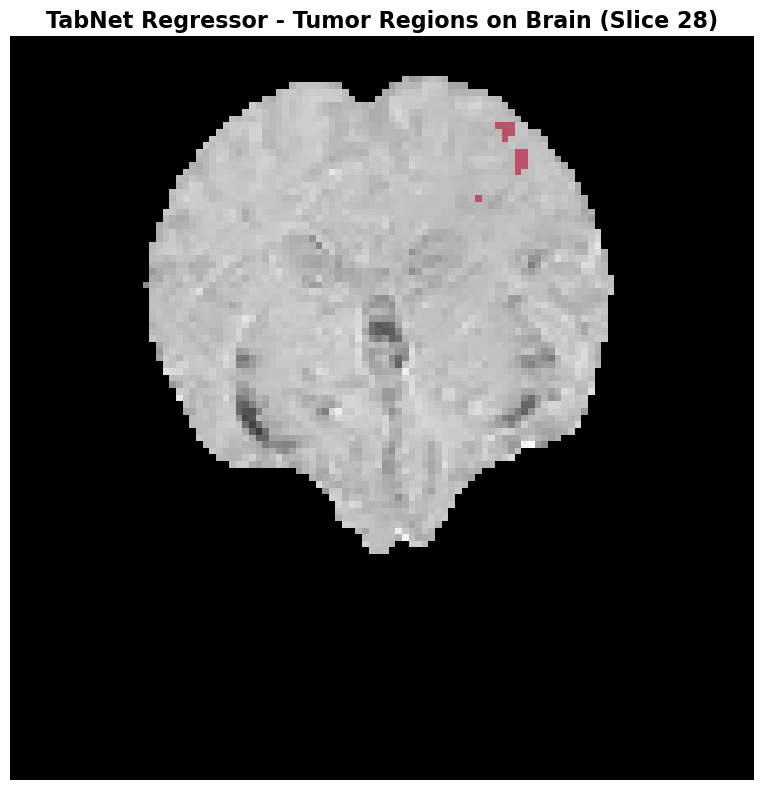

In [6]:
# 1. TUMOR LOCATION OVERLAY ON BRAIN
print("TabNet Regressor - Tumor Location Overlay Visualization")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
brain_slice_28 = data[:, :, 28, 0].T  # b=0 image, transposed
ax.imshow(brain_slice_28, cmap='gray', aspect='equal')

# Overlay tumor regions with inferno colors
for i, (tumor_name, roi_mask) in enumerate(tumor_regions.items()):
    tumor_slice = roi_mask[:, :, 28].T  # Transpose tumor slice
    if np.any(tumor_slice):
        tumor_overlay = np.ma.masked_where(~tumor_slice, tumor_slice)
        ax.imshow(tumor_overlay, cmap='inferno', alpha=0.8, aspect='equal', vmin=0, vmax=2)

ax.set_title('TabNet Regressor - Tumor Regions on Brain (Slice 28)', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

TabNet Regressor - VERDICT Parameter Comparison


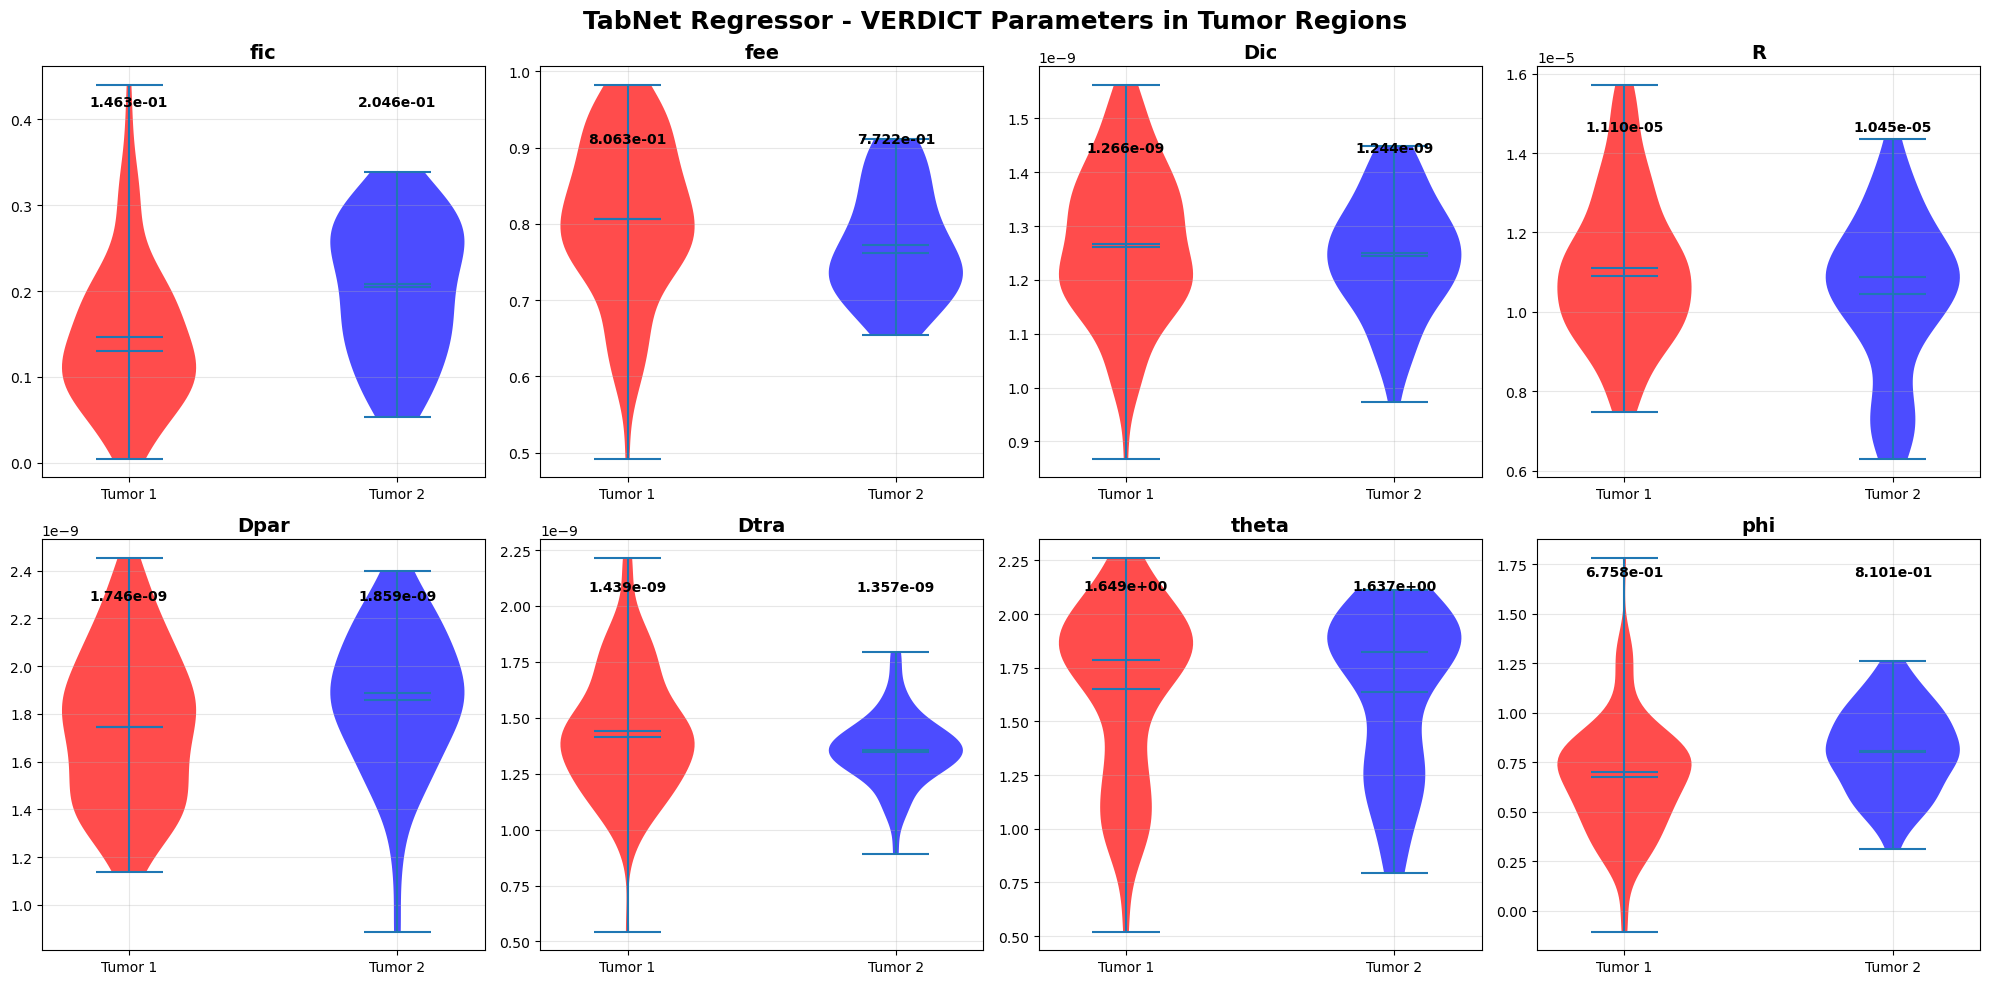

In [7]:
# 2. TABNET REGRESSOR PARAMETER COMPARISON
print("TabNet Regressor - VERDICT Parameter Comparison")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('TabNet Regressor - VERDICT Parameters in Tumor Regions', fontsize=18, fontweight='bold')

axes = axes.flatten()
colors = ['red', 'blue']
tumor_names = list(tumor_verdict_params.keys())

for i, param_name in enumerate(param_names):
    ax = axes[i]
    
    data_to_plot = []
    labels = []
    
    for j, tumor_name in enumerate(tumor_names):
        param_values = tumor_verdict_params[tumor_name][:, i]
        data_to_plot.append(param_values)
        labels.append(tumor_name.replace('_', ' '))
    
    # Create violin plot
    parts = ax.violinplot(data_to_plot, positions=range(len(data_to_plot)), 
                         showmeans=True, showmedians=True)
    
    # Color the violin plots
    for pc, color in zip(parts['bodies'], colors[:len(data_to_plot)]):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax.set_title(f'{param_name}', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.grid(True, alpha=0.3)
    
    # Add mean values as text
    for j, tumor_name in enumerate(tumor_names):
        mean_val = tumor_stats[tumor_name][param_name]['mean']
        ax.text(j, ax.get_ylim()[1]*0.9, f'{mean_val:.3e}', 
               ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

TabNet Regressor - Attention Analysis


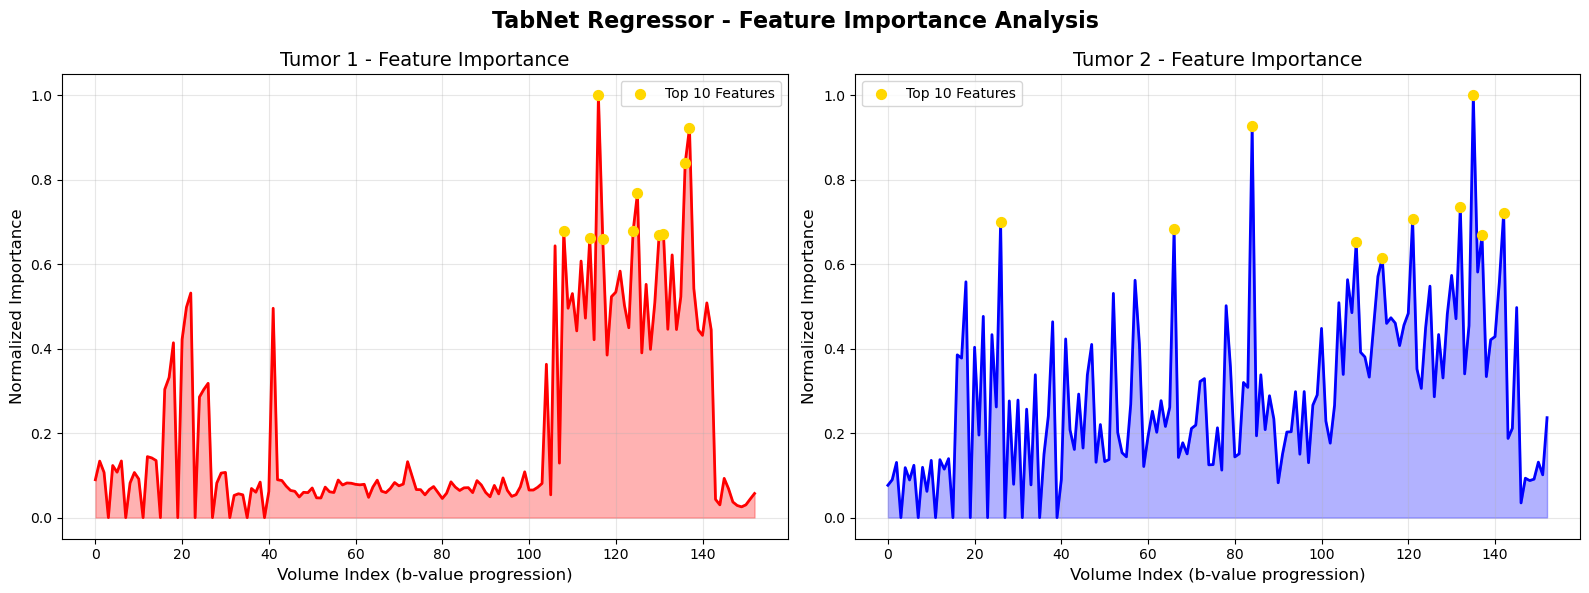

In [8]:
# 3. TABNET ATTENTION ANALYSIS (if available)
print("TabNet Regressor - Attention Analysis")

# Since TabNet has attention mechanisms, let's try to visualize feature importance
# This requires modifying the forward pass to return attention weights
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('TabNet Regressor - Feature Importance Analysis', fontsize=16, fontweight='bold')

for i, (tumor_name, tumor_signal) in enumerate(tumor_signals.items()):
    ax = axes[i]
    
    # Calculate feature importance based on signal variance
    feature_importance = np.var(tumor_signal, axis=0)
    feature_importance_normalized = feature_importance / feature_importance.max()
    
    # Plot feature importance
    ax.plot(feature_importance_normalized, linewidth=2, color=['red', 'blue'][i])
    ax.fill_between(range(len(feature_importance_normalized)), 
                   feature_importance_normalized, alpha=0.3, color=['red', 'blue'][i])
    
    ax.set_title(f'{tumor_name.replace("_", " ")} - Feature Importance', fontsize=14)
    ax.set_xlabel('Volume Index (b-value progression)', fontsize=12)
    ax.set_ylabel('Normalized Importance', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Highlight top important features
    top_features = np.argsort(feature_importance_normalized)[-10:]
    ax.scatter(top_features, feature_importance_normalized[top_features], 
              color='gold', s=50, zorder=5, label='Top 10 Features')
    ax.legend()

plt.tight_layout()
plt.show()

TabNet Regressor - DWI Signal Profiles in Tumor Regions


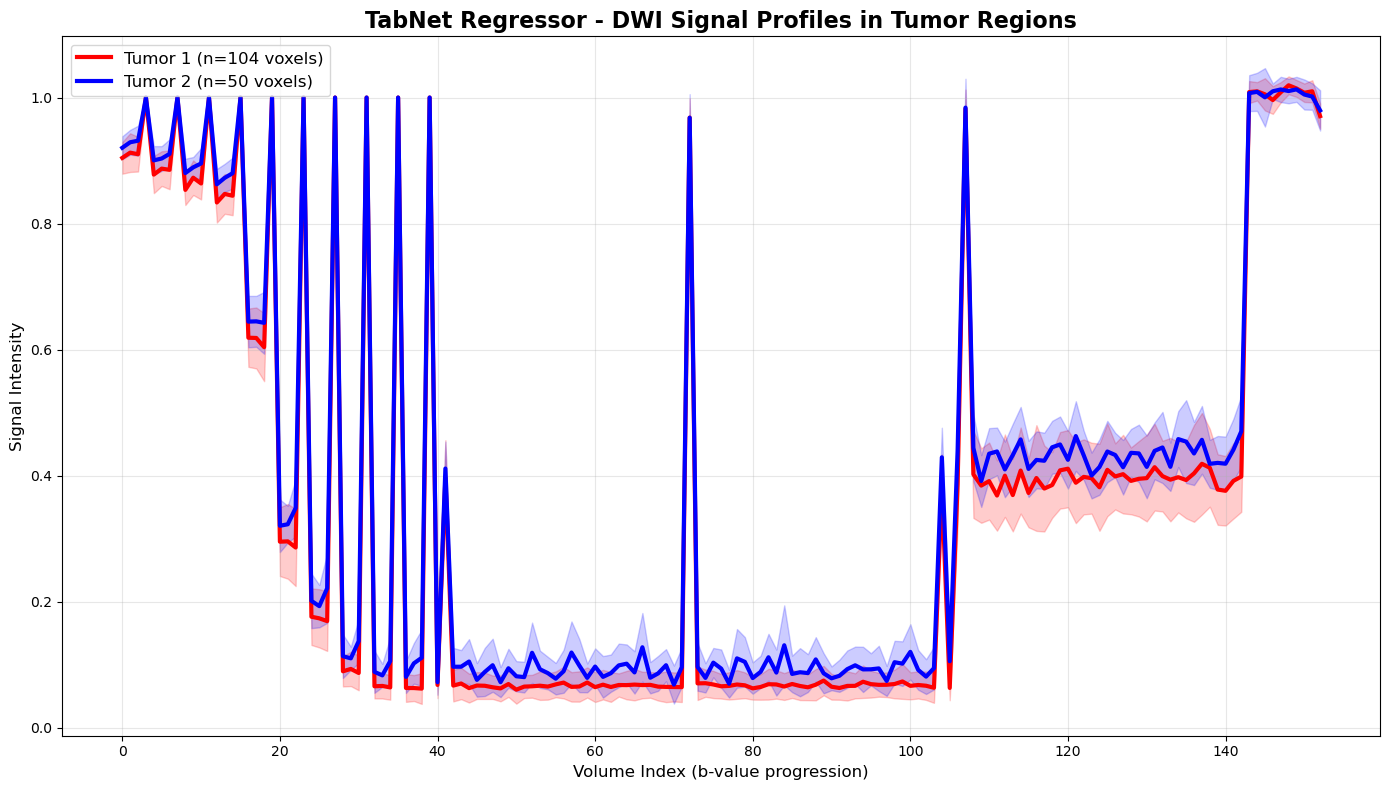

In [9]:
# 4. SIGNAL PROFILES COMPARISON
print("TabNet Regressor - DWI Signal Profiles in Tumor Regions")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

for i, (tumor_name, tumor_signal) in enumerate(tumor_signals.items()):
    mean_signal = tumor_signal.mean(axis=0)
    std_signal = tumor_signal.std(axis=0)
    volumes = np.arange(len(mean_signal))
    
    color = ['red', 'blue'][i]
    ax.plot(volumes, mean_signal, color=color, linewidth=3, 
            label=f'{tumor_name.replace("_", " ")} (n={tumor_signal.shape[0]} voxels)')
    ax.fill_between(volumes, mean_signal - std_signal, mean_signal + std_signal, 
                    color=color, alpha=0.2)

ax.set_xlabel('Volume Index (b-value progression)', fontsize=12)
ax.set_ylabel('Signal Intensity', fontsize=12)
ax.set_title('TabNet Regressor - DWI Signal Profiles in Tumor Regions', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

TabNet Regressor - Clinical Tumor Assessment Summary


C:\Users\yz237\AppData\Local\Temp\ipykernel_95944\2750316940.py:44: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\yz237\AppData\Local\Temp\ipykernel_95944\2750316940.py:44: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\yz237\miniconda3\envs\verdict\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yz237\miniconda3\envs\verdict\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


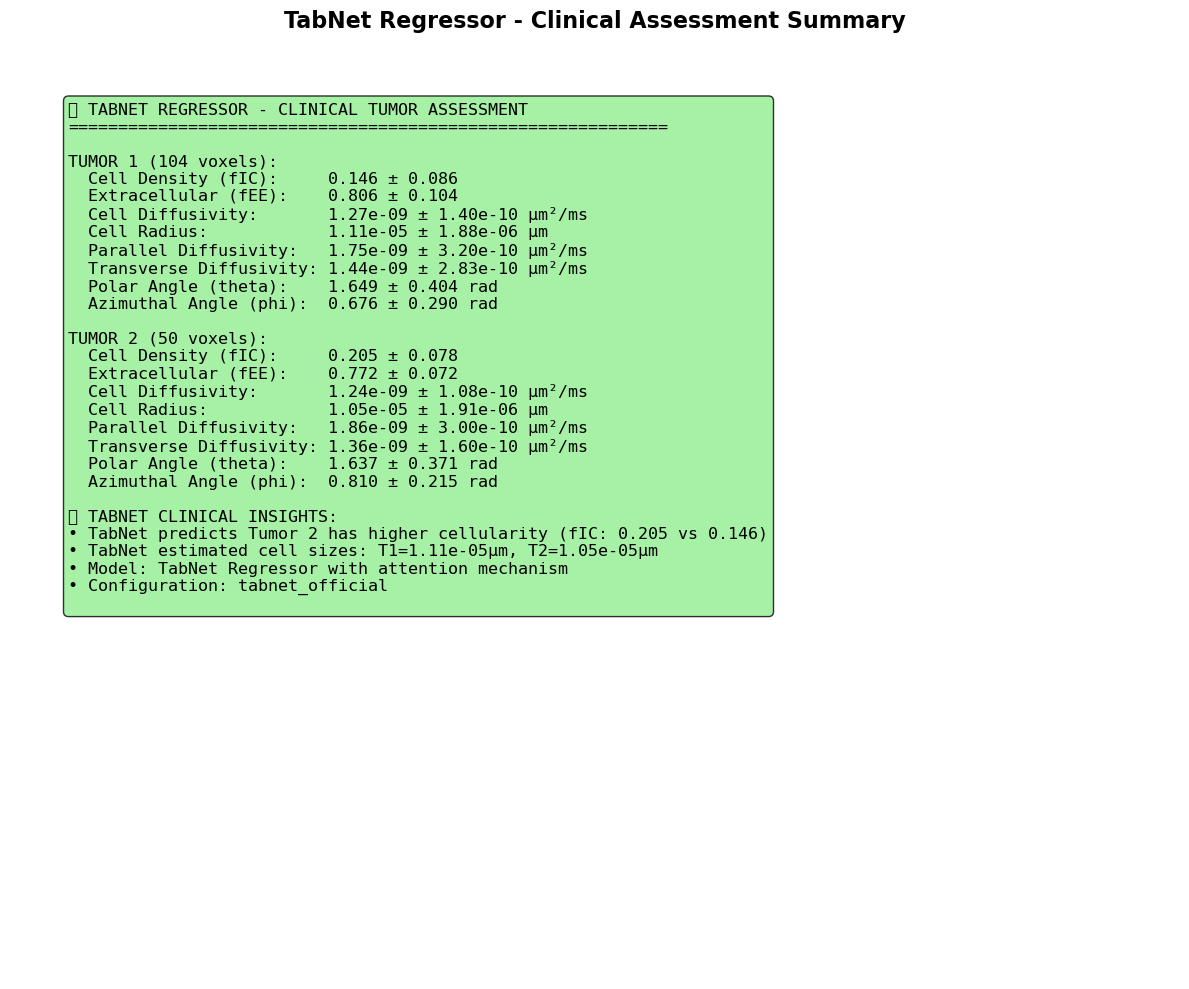

In [ ]:
# 5. CLINICAL PARAMETER SUMMARY FOR TABNET
print("TabNet Regressor - Clinical Tumor Assessment Summary")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.axis('off')

# Create summary text
summary_text = " TABNET REGRESSOR - CLINICAL TUMOR ASSESSMENT\n" + "="*60 + "\n\n"

tumor_names = list(tumor_verdict_params.keys())
for tumor_name in tumor_names:
    roi_num = tumor_name.split('_')[1]
    stats = tumor_stats[tumor_name]
    
    summary_text += f"TUMOR {roi_num} ({tumor_verdict_params[tumor_name].shape[0]} voxels):\n"
    summary_text += f"  Cell Density (fIC):     {stats['fic']['mean']:.3f} ± {stats['fic']['std']:.3f}\n"
    summary_text += f"  Extracellular (fEE):    {stats['fee']['mean']:.3f} ± {stats['fee']['std']:.3f}\n"
    summary_text += f"  Cell Diffusivity:       {stats['Dic']['mean']:.2e} ± {stats['Dic']['std']:.2e} μm²/ms\n"
    summary_text += f"  Cell Radius:            {stats['R']['mean']:.2e} ± {stats['R']['std']:.2e} μm\n"
    summary_text += f"  Parallel Diffusivity:   {stats['Dpar']['mean']:.2e} ± {stats['Dpar']['std']:.2e} μm²/ms\n"
    summary_text += f"  Transverse Diffusivity: {stats['Dtra']['mean']:.2e} ± {stats['Dtra']['std']:.2e} μm²/ms\n"
    summary_text += f"  Polar Angle (theta):    {stats['theta']['mean']:.3f} ± {stats['theta']['std']:.3f} rad\n"
    summary_text += f"  Azimuthal Angle (phi):  {stats['phi']['mean']:.3f} ± {stats['phi']['std']:.3f} rad\n\n"

# Add clinical interpretation
summary_text += " TABNET CLINICAL INSIGHTS:\n"
tumor1_fic = tumor_stats['Tumor_1']['fic']['mean']
tumor2_fic = tumor_stats['Tumor_2']['fic']['mean']

if tumor1_fic > tumor2_fic:
    summary_text += f"• TabNet predicts Tumor 1 has higher cellularity (fIC: {tumor1_fic:.3f} vs {tumor2_fic:.3f})\n"
else:
    summary_text += f"• TabNet predicts Tumor 2 has higher cellularity (fIC: {tumor2_fic:.3f} vs {tumor1_fic:.3f})\n"

summary_text += f"• TabNet estimated cell sizes: T1={tumor_stats['Tumor_1']['R']['mean']:.2e}μm, T2={tumor_stats['Tumor_2']['R']['mean']:.2e}μm\n"
summary_text += f"• Model: TabNet Regressor with attention mechanism\n"
summary_text += f"• Configuration: {tabnet_config.get('wandb_run_name', 'tabnet_official')}\n"

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.title('TabNet Regressor - Clinical Assessment Summary', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# BRAIN IMAGES WITH TUMOR REGION MARKINGS - TABNET VERSION
print("\n🧠 TABNET REGRESSOR - BRAIN VISUALIZATION WITH TUMOR REGION MARKERS")
print("=" * 70)

# Import additional libraries for enhanced visualization
from scipy import ndimage
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as patches

# First, let's check which slices actually contain tumor regions
print("TabNet Analysis - Checking tumor presence across slices...")
slice_tumor_info = {}
for slice_idx in [30]:  # Only check slice 30
    slice_tumor_info[slice_idx] = {}
    for tumor_name, roi_mask in tumor_regions.items():
        tumor_slice = roi_mask[:, :, slice_idx]
        tumor_count = np.sum(tumor_slice)
        slice_tumor_info[slice_idx][tumor_name] = tumor_count
        print(f"Slice {slice_idx}, {tumor_name}: {tumor_count} voxels")

# Create comprehensive brain visualization with tumor markings
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle('TabNet Regressor - Patient08 Brain with Tumor Region Markings - Slice 30', 
             fontsize=18, fontweight='bold', y=0.95)

# Define slice to show
slice_idx = 30  # Only slice 30

# Custom colormap for better tumor visualization
tumor_colors = ['#000000', '#FF6B35', '#F7931E']  # Black, Orange-Red, Yellow-Orange
tumor_cmap = ListedColormap(tumor_colors)

# Brain with enhanced tumor overlay
# Show brain slice with enhanced contrast
brain_slice = data[:, :, slice_idx, 0].T  # b=0 image, transposed

# Enhance brain contrast using histogram equalization
brain_normalized = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min())
brain_enhanced = np.power(brain_normalized, 0.7)  # Gamma correction for better contrast

ax.imshow(brain_enhanced, cmap='gray', aspect='equal', alpha=0.95, vmin=0, vmax=1)

# Create combined tumor mask for this slice
combined_tumor_mask = np.zeros_like(brain_slice)
tumor_boundaries = np.zeros_like(brain_slice)

# Process all tumor regions for this slice
for tumor_name, roi_mask in tumor_regions.items():
    tumor_slice = roi_mask[:, :, slice_idx].T
    tumor_num = int(tumor_name.split('_')[1])
    
    # Check if tumor exists in this slice
    if np.any(tumor_slice):
        print(f"  Slice {slice_idx}: Found {tumor_name} with {np.sum(tumor_slice)} voxels")
        combined_tumor_mask[tumor_slice] = tumor_num
        
        # Create enhanced tumor boundaries
        dilated = ndimage.binary_dilation(tumor_slice, structure=np.ones((3,3)))
        eroded = ndimage.binary_erosion(tumor_slice, structure=np.ones((2,2)))
        boundary = dilated & ~eroded
        tumor_boundaries[boundary] = tumor_num
    else:
        print(f"  Slice {slice_idx}: No {tumor_name} found")

# Display tumor regions with custom colormap
if np.any(combined_tumor_mask > 0):
    tumor_overlay = np.ma.masked_where(combined_tumor_mask == 0, combined_tumor_mask)
    ax.imshow(tumor_overlay, cmap=tumor_cmap, alpha=0.7, aspect='equal', vmin=0, vmax=2)

# Display tumor boundaries with high contrast
if np.any(tumor_boundaries > 0):
    boundary_overlay = np.ma.masked_where(tumor_boundaries == 0, tumor_boundaries)
    ax.imshow(boundary_overlay, cmap='plasma', alpha=0.9, aspect='equal', vmin=0, vmax=2)

# Add tumor labels with improved positioning for all tumors
labels_added = []
for tumor_name, roi_mask in tumor_regions.items():
    tumor_slice = roi_mask[:, :, slice_idx].T
    tumor_num = int(tumor_name.split('_')[1])
    
    if np.any(tumor_slice):
        coords = np.where(tumor_slice)
        if len(coords[0]) > 0:
            centroid_y, centroid_x = coords[0].mean(), coords[1].mean()
            
            # Adjust label positions to avoid overlap
            if tumor_num == 1:
                offset_x, offset_y = 20, -20
            else:  # tumor_num == 2
                offset_x, offset_y = -20, 20
            
            # Add arrow pointing to tumor center with TabNet label
            ax.annotate(f'TabNet Tumor {tumor_num}', 
                       xy=(centroid_x, centroid_y),
                       xytext=(centroid_x + offset_x, centroid_y + offset_y),
                       arrowprops=dict(arrowstyle='->', color='cyan', lw=3, 
                                     connectionstyle=f"arc3,rad={0.2 if tumor_num==1 else -0.2}"),
                       fontsize=11, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round,pad=0.4', 
                               facecolor=['darkred', 'darkblue'][tumor_num-1], 
                               alpha=0.8, edgecolor='cyan', linewidth=2))
            labels_added.append(tumor_num)
    else:
        # Add text note for missing tumors
        ax.text(0.02, 0.98 - 0.05*tumor_num, f'TabNet Tumor {tumor_num}: Not present in this slice', 
               transform=ax.transAxes, fontsize=9, color='yellow',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

ax.set_title(f'TabNet Brain Analysis + Tumors (Slice {slice_idx})', fontsize=13, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust to prevent title overlap
plt.show()

# Create tumor statistics summary
print("\n📊 TABNET REGRESSOR - TUMOR REGION SUMMARY:")
print("-" * 50)
total_tumor_voxels = 0
for tumor_name, roi_mask in tumor_regions.items():
    tumor_num = tumor_name.split('_')[1]
    voxel_count = np.sum(roi_mask)
    total_tumor_voxels += voxel_count
    
    # Calculate tumor volume (assuming 1mm³ per voxel)
    tumor_volume_mm3 = voxel_count  # 1 voxel = 1 mm³
    
    print(f"🔴 TabNet Tumor {tumor_num}:")
    print(f"   Voxels: {voxel_count}")
    print(f"   Volume: ~{tumor_volume_mm3:.1f} mm³")
    
    # Get tumor location info
    coords = np.where(roi_mask)
    if len(coords[0]) > 0:
        centroid = (coords[0].mean(), coords[1].mean(), coords[2].mean())
        print(f"   3D Centroid: ({centroid[0]:.1f}, {centroid[1]:.1f}, {centroid[2]:.1f})")
        print(f"   Z-range: {coords[2].min()} - {coords[2].max()} (slices)")
    print()

print(f"📈 TABNET TOTAL TUMOR BURDEN:")
print(f"   Combined voxels: {total_tumor_voxels}")
print(f"   Combined volume: ~{total_tumor_voxels:.1f} mm³")
brain_voxels = np.sum(np.any(data > 0, axis=3))
tumor_percentage = (total_tumor_voxels / brain_voxels) * 100
print(f"   % of brain tissue: {tumor_percentage:.3f}%")
print(f"   Analysis method: TabNet Regressor with Attention")
print("-" * 50)